In [1]:
import numpy as np
import astropy.io.fits as fits
import pdb
import astropy.coordinates as c
from astropy.table import Table
import astropy.units as u
import mpl_toolkits.basemap
import matplotlib.pyplot as plt

In [2]:
import desitarget.mock.io as mock_io
from desitarget import mws_mask
import desiutil.plots as desiplots

In [3]:
%matplotlib inline

In [4]:
import sys
sys.path.append('/global/homes/c/crockosi/bright_analysis/py/bright_analysis/')
import sweeps.io as sweeps

In [5]:
data = fits.getdata('targetselection/2017/galaxia_gaia_v005.fits')

In [6]:
pmtotall = np.sqrt(data['PM_RA_STAR_GAIA']**2+data['PM_DEC_GAIA']**2)
dmall = data['DM']
glat = data['b']
glong = data['l']
gmagall = data['SDSSg_obs']
rmagall = data['SDSSr_obs']
gmrall = gmagall-rmagall
pxall = data['PARALLAX_GAIA']

In [7]:
import healpy as hpy
thetab = np.deg2rad(90.-glat)
phil = np.deg2rad(glong)

Nside = 16<br>
That's 3072 bins.<br>
13.4 square degrees per bin

In [8]:
nside = 16
nbins = hpy.nside2npix(nside)
print(nbins)

3072


In [9]:
ibins = hpy.ang2pix(nside,thetab,phil,nest=True)
ipix,ibincounts = np.unique(ibins,return_counts=True)
allpix_count = np.zeros(hpy.nside2npix(nside),dtype=np.float32)
allpix_count[ipix] = ibincountsglatforfullbins = np.zeros(nbins)
glongforfullbins = np.zeros(nbins)

/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


In [10]:
emptythresh = 16000.
binidx,ibin_count    = np.unique(ibins,return_counts=True)
allbins = np.arange(nbins)
allbincount       = np.zeros(nbins,dtype=np.float32)
allbincount[binidx] = ibin_count
ifull = allbincount > emptythresh
fullbins = allbins[ifull]
nfull = len(fullbins)
print(nfull)

1159


In [11]:
glatforfullbins = np.zeros(nbins)
glongforfullbins = np.zeros(nbins)
for i in range(len(fullbins)):
    bidx = fullbins[i]
    inbin, = np.where(ibins == bidx)
    glatforfullbins[bidx] = np.mean(glat[inbin])
    glongforfullbins[bidx] = np.mean(glong[inbin])

ntake is number of spectra we expect to get per 13.4 sq. degree bin.  Computed from assuming we get half the 5000 fibers for each 7.5 square degree DESI tile

In [12]:
ntake = 4476

In [13]:
# pmcut: take only objects with pmtotal less than this value
# gmrcut: impose a pmcut only redder than this g-r value
# dmvec: values of dm where we evaluate sampling completeness and pm incompleteness
# samplefracvec: a vector of fractions, compute number bins with higher percentage of stars that make the PM cut and get fibers than the values in <sampling fractions> 
# ntake: number of spectra we expect to get per bin
# incomplimit: at each value of DM, return how much area loses this fraction of objets to the proper motion cut
# nbins: total number of healpix bins
# fullbins: number of bins that have num objects over threshold
# ibins: vector of bin numbers for each object
# dmall: vector of distance modulus values for each object
# pmtotall: vector of observed total proper motion for each object, mas/year
# gmrall: vector of g-r values for each object
def mwstscuts(pmcut, gmrcut, ntake, incomplimit, dmvec, samplefracvec, nbins, fullbins, ibins, dmall, pmtotall, gmrall):

    # sampling completeness vec
    samplevec = np.zeros(nbins)
    # distmode completeness vec
    dmcomp = np.zeros((len(dmvec),nbins))
    pmincomp = np.zeros((len(dmvec),nbins))
    for i in range(len(fullbins)):
        bidx = fullbins[i]
        # objects in bin. do this first to keep code fast
        inbin, = np.where(ibins == bidx)
        # that also pass gmr and pm cut. only impose the pm cut for objects redder than the gmr cut
        # this is the total number of objects in this bin eligible to get a fiber
        ipm, = np.where((gmrall[inbin] < gmrcut) | ((pmtotall[inbin] < pmcut) & (gmrall[inbin] > gmrcut)))
        # compute samplefrac: if we have fewer fibers than objects in the bin we will only get <samplefrac> of the
        # objects.  Because we have used all the targetting information to determine <ipm>, we subsample any
        # sub-population of the bin (for example, in distance) by that sampling fraction.
        samplefrac = ntake/len(ipm)
        if (samplefrac) > 1.0:
            samplefrac = 1.0
        samplevec[bidx] = samplefrac
        # now loop through dm values
        for dmi in range(len(dmvec)):
            dmcut = dmvec[dmi]
            # obj in bin that pass the distmod cut
            dinbin, = np.where(dmall[inbin] > dmcut)
            # obj in bin that pass both the distmod and pmtotal cuts, as above
            dinbincut, = np.where((dmall[inbin] > dmcut) & ((gmrall[inbin] < gmrcut) | ((pmtotall[inbin] < pmcut) & (gmrall[inbin] > gmrcut))))                                     
            # number objects that pass distmod+pm cut multiplied by the sampling fraction for this bin.  
            # tha is the number of these distant objects that will get fibers 
            dmtake = len(dinbin)*samplefrac
            dmcomp[dmi,bidx] = len(dinbincut)*samplefrac/len(dinbin)
            # ratio number objects that pass distmod pm cut but not the pm cut to number that pass the distmod cut
            pmincomp[dmi,bidx] = (len(dinbin)-len(dinbincut))/len(dinbin)
    # number of bins that have total sampling fraction greater than <incompcut>
    ibig, = np.where(samplevec > incomplimit)
    pst = 'samplevec '+str(len(ibig))
    #print(pst)
    # now sum along the bins to get total area at each <dm> that is better than each value of <samplefracvec>
    samplefrac = np.zeros((len(dmvec),len(samplefracvec)))
    pmincompvec = np.zeros(len(dmvec)) 
    for dmi in range(len(dmvec)):
        pst = 'dm '+str(dmvec[dmi])
        #print(pst)
        ipminc, = np.where(pmincomp[dmi,:] > incomplimit)
        pmincompvec[dmi] = len(ipminc)
        pst = 'pmincomp '+str(len(ipminc))
        #print(pst)
        for j in range(len(samplefracvec)):
            frac = samplefracvec[j]
            pst = 'frac '+str(frac)
            #print(pst)
            ifrac, = np.where(dmcomp[dmi,:] > frac)
            samplefrac[dmi,j] = len(ifrac)
            pst = 'samplefrac '+str(len(ifrac))
            #print(pst)
    #import pdb
    #pdb.set_trace()
    return samplefrac,pmincompvec,dmcomp,pmincomp

In [14]:
def trypmcuts(pmcutvec, gmrcut, ntake, incomplimit, dmvec, samplefracvec, nbins, fullbins, ibins, dmall, pmtotall, gmrall):

    # output is a 3D array: ((pmcutvec),(dmvec),(samplefracvec))
    outinfo = np.zeros((len(pmcutvec),len(dmvec),len(samplefracvec)))
    outincompvec = np.zeros((len(pmcutvec),len(dmvec)))
    outsamplebins = np.zeros((len(pmcutvec),len(dmvec),nbins))
    outincompbins = np.zeros((len(pmcutvec),len(dmvec),nbins))
    for pmi in range(len(pmcutvec)):
        onesamplefrac,onepmincompvec,onedmcomp,onepmincomp = mwstscuts(pmcutvec[pmi], gmrcut, ntake, incomplimit, dmvec, samplefracvec, nbins, fullbins, ibins, dmall, pmtotall, gmrall)
        outinfo[pmi,:,:] = onesamplefrac
        outincompvec[pmi,:] = onepmincompvec
        outsamplebins[pmi,:,:] = onedmcomp
        outincompbins[pmi,:,:] = onepmincomp
    return outinfo,outincompvec,outsamplebins,outincompbins


In [15]:
pmcutvec = np.asarray([1.0,3.0,5.0,7.0,10.0])
dmvec = np.asarray([13.5,15.,16.,17.,18.5])
samplefracs = np.asarray([0.3, 0.5, 0.75, 0.9])

In [16]:
samplefrac_0505,pmimcompfrac_0505,samplebins_0505,incompbins_0505 = trypmcuts(pmcutvec, 0.5, ntake, 0.5, dmvec, samplefracs, nbins, fullbins, ibins, dmall, pmtotall, gmrall)

In [17]:
samplefrac_0605,pmimcompfrac_0605,samplebins_0605,incompbins_0605 = trypmcuts(pmcutvec, 0.6, ntake, 0.5, dmvec, samplefracs, nbins, fullbins, ibins, dmall, pmtotall, gmrall)

In [18]:
samplefrac_0705,pmimcompfrac_0705,samplebins_0705,incompbins_0705 = trypmcuts(pmcutvec, 0.7, ntake, 0.5, dmvec, samplefracs, nbins, fullbins, ibins, dmall, pmtotall, gmrall)

In [19]:
samplefrac_0805,pmimcompfrac_0805,samplebins_0805,incompbins_0805 = trypmcuts(pmcutvec, 0.8, ntake, 0.5, dmvec, samplefracs, nbins, fullbins, ibins, dmall, pmtotall, gmrall)

In [20]:
samplefrac_1005,pmimcompfrac_1005,samplebins_1005,incompbins_1005 = trypmcuts(pmcutvec, 1.0, ntake, 0.5, dmvec, samplefracs, nbins, fullbins, ibins, dmall, pmtotall, gmrall) 

In [21]:
samplefrac_0205,pmimcompfrac_0205,samplebins_0205,incompbins_2005 = trypmcuts(pmcutvec, 0.2, ntake, 0.5, dmvec, samplefracs, nbins, fullbins, ibins, dmall, pmtotall, gmrall)

In [201]:
def tscompplots(pmcutvec,samplefrac,dmvec,samplefracs):
    lslist = ['--','-','-.',':']
    clist = ['C0','C2','C3','C4','C5'] # blue green red purple brown.  DM indicated by color
    for i in range(len(dmvec)):
        plt.plot(pmcutvec,samplefrac[:,i,0],clist[i],linestyle='--')
        plt.plot(pmcutvec,samplefrac[:,i,1],clist[i],linestyle='-')
        plt.plot(pmcutvec,samplefrac[:,i,2],clist[i],linestyle='-.')
        plt.plot(pmcutvec,samplefrac[:,i,3],clist[i],linestyle=':')
        plt.xlabel('PM cut, mas/year')
        plt.ylabel('Number of healpy bin > sampling fraction')


In [23]:
def tsincompplots(pmcutvec,pmincompfrac,dmvec):
    clist = ['C0','C2','C3','C4','C5'] # blue green red purple brown
    for i in range(len(dmvec)):
        plt.plot(pmcutvec,pmincompfrac[:,i],clist[i])

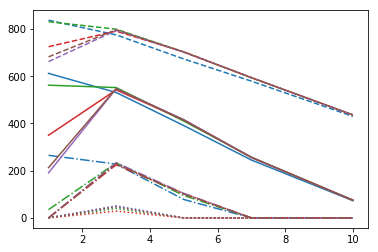

In [24]:
tscompplots(pmcutvec,samplefrac_0505,dmvec,samplefracs)

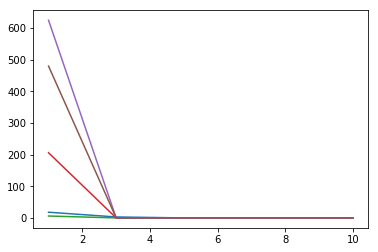

In [25]:
tsincompplots(pmcutvec,pmimcompfrac_0505,dmvec)

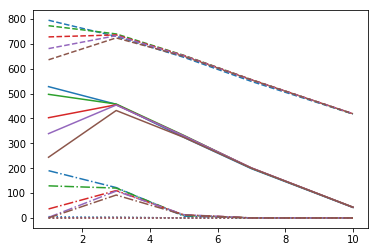

In [26]:
tscompplots(pmcutvec,samplefrac_0605,dmvec,samplefracs)

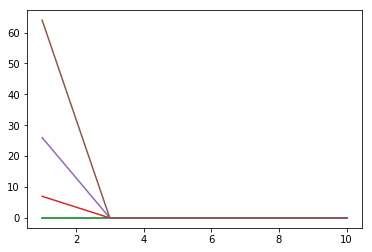

In [27]:
tsincompplots(pmcutvec,pmimcompfrac_0605,dmvec)

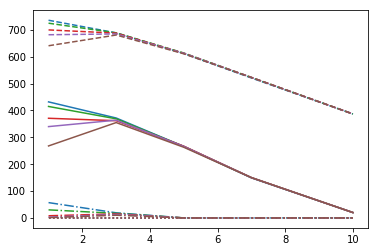

In [28]:
tscompplots(pmcutvec,samplefrac_0705,dmvec,samplefracs)

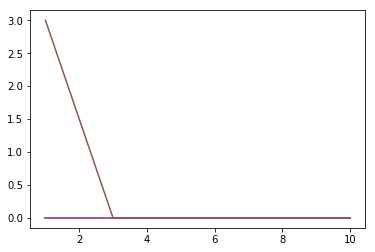

In [29]:
tsincompplots(pmcutvec,pmimcompfrac_0705,dmvec)

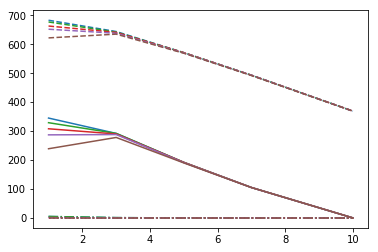

In [30]:
tscompplots(pmcutvec,samplefrac_0805,dmvec,samplefracs)

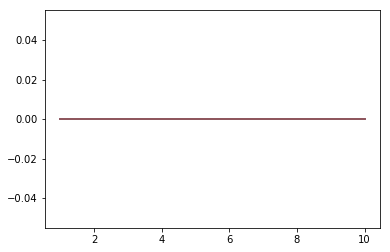

In [31]:
tsincompplots(pmcutvec,pmimcompfrac_0805,dmvec)

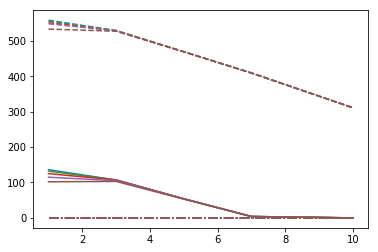

In [32]:
tscompplots(pmcutvec,samplefrac_1005,dmvec,samplefracs)

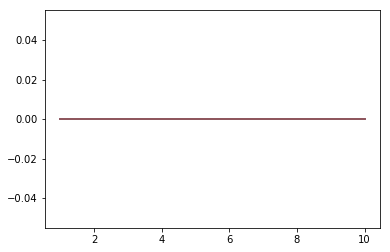

In [33]:
tsincompplots(pmcutvec,pmimcompfrac_1005,dmvec)

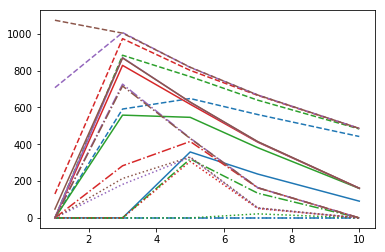

In [34]:
tscompplots(pmcutvec,samplefrac_0205,dmvec,samplefracs)

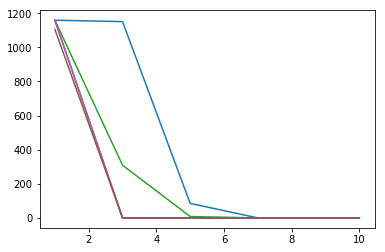

In [35]:
tsincompplots(pmcutvec,pmimcompfrac_0205,dmvec)

In [165]:
inbin, = np.where(ibins == fullbins[200])

In [113]:
glatforfullbins[fullbins[200]]

63.410686492919922

In [114]:
glongforfullbins[fullbins[200]]

14.980860710144043

In [124]:
glongforfullbins[fullbins[550]]

200.44903564453125

In [123]:
glatforfullbins[fullbins[550]]

57.362506866455078

In [137]:
glongforfullbins[fullbins[320]]

106.86578369140625

In [138]:
glatforfullbins[fullbins[320]]

38.627243041992188

In [187]:
inbin, = np.where(ibins == fullbins[320])

(0.1, 1.6)

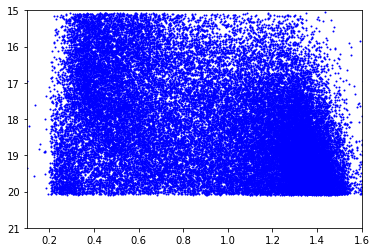

In [140]:
plt.plot(gmrall[inbin],rmagall[inbin],'bo',mew=0,ms=2.)
plt.ylim(21,15)
plt.xlim(0.1,1.6)

(5, 25)

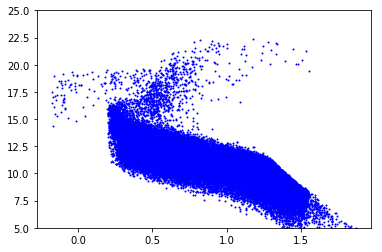

In [141]:
plt.plot(gmrall[inbin],dmall[inbin],'bo',mew=0,ms=2.)
plt.ylim(5,25)

(0, 40)

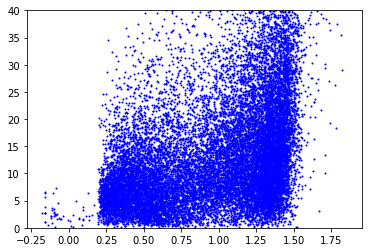

In [174]:
plt.plot(gmrall[inbin],pmtotall[inbin],'bo',mew=0,ms=2.)
plt.ylim(0,40)

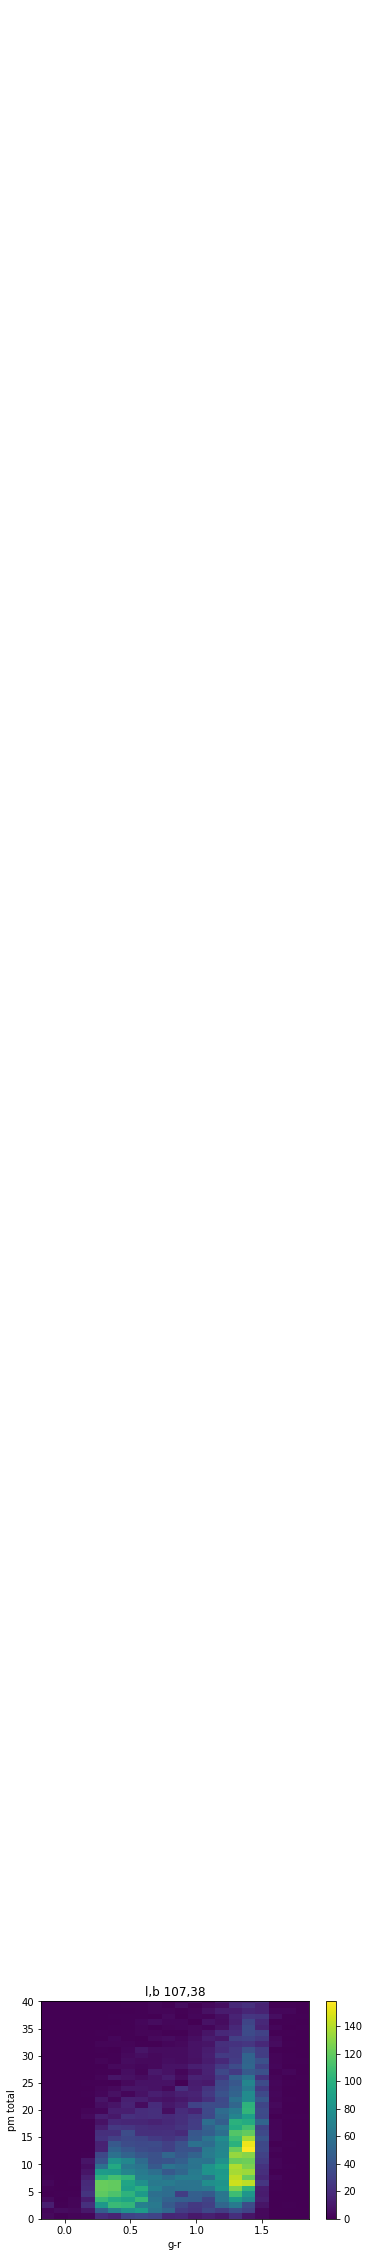

In [202]:
plt.hist2d(gmrall[inbin],pmtotall[inbin],bins=[20,400],cmax=1000)
plt.ylim(0,40)
plt.ylabel('pm total')
plt.xlabel('g-r')
plt.title('l,b 107,38')
plt.colorbar()

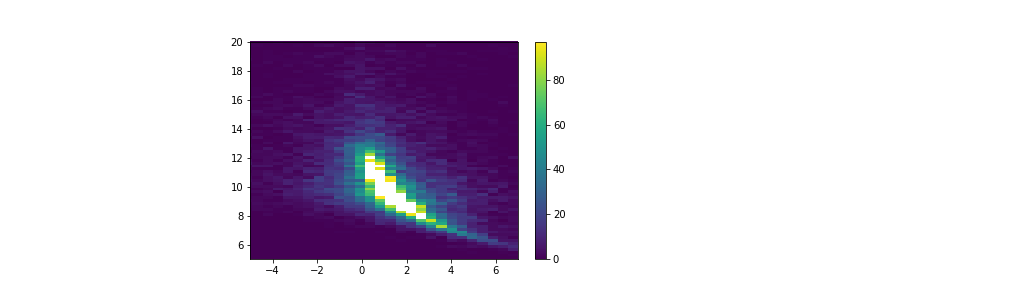

In [180]:
plt.hist2d(pxall[inbin],dmall[inbin],bins=[100,100],cmax=100)
plt.xlim(-5,7)
plt.ylim(5,20)
plt.colorbar()

(5, 22)

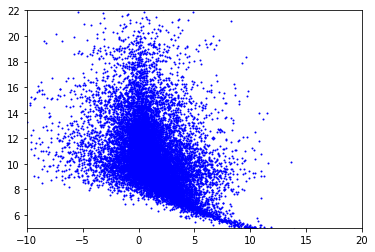

In [179]:
plt.plot(pxall[inbin],dmall[inbin],'bo',mew=0,ms=2.)
plt.xlim(-10,20)
plt.ylim(5,22)

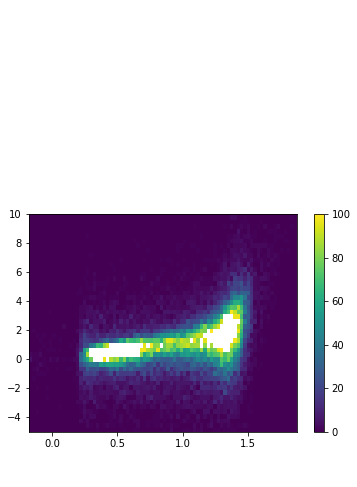

In [152]:
plt.hist2d(gmrall[inbin],pxall[inbin],bins=[80,100],cmax=100)
plt.ylim(-5,10)
plt.colorbar()

In [166]:
ipm, = np.where((gmrall[inbin] < 0.6) | ((pmtotall[inbin] < 3.) & (gmrall[inbin] > 0.6)))

In [167]:
len(gmrall[inbin[ipm]])

11966

(0.1, 1.6)

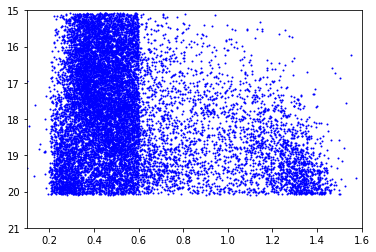

In [148]:
plt.plot(gmrall[inbin[ipm]],rmagall[inbin[ipm]],'bo',mew=0,ms=2.)
plt.ylim(21,15)
plt.xlim(0.1,1.6)

(5, 25)

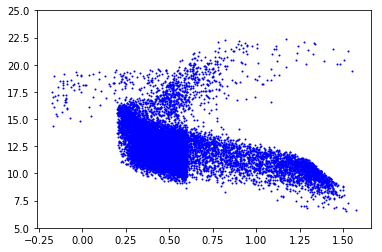

In [149]:
plt.plot(gmrall[inbin[ipm]],dmall[inbin[ipm]],'bo',mew=0,ms=2.)
plt.ylim(5,25)

In [192]:
inbin, = np.where(ibins == fullbins[550])

(0.1, 1.6)

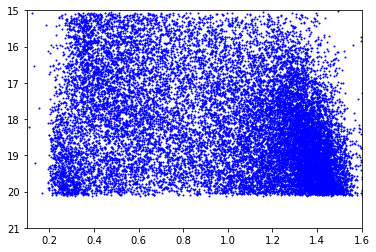

In [154]:
plt.plot(gmrall[inbin],rmagall[inbin],'bo',mew=0,ms=2.)
plt.ylim(21,15)
plt.xlim(0.1,1.6)

(5, 25)

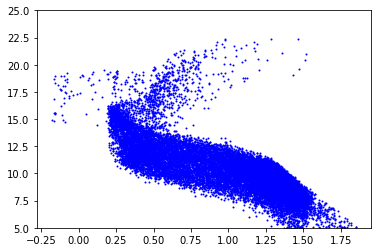

In [155]:
plt.plot(gmrall[inbin],dmall[inbin],'bo',mew=0,ms=2.)
plt.ylim(5,25)

(0, 40)

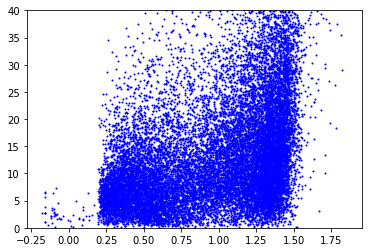

In [173]:
plt.plot(gmrall[inbin],pmtotall[inbin],'bo',mew=0,ms=2.)
plt.ylim(0,40)

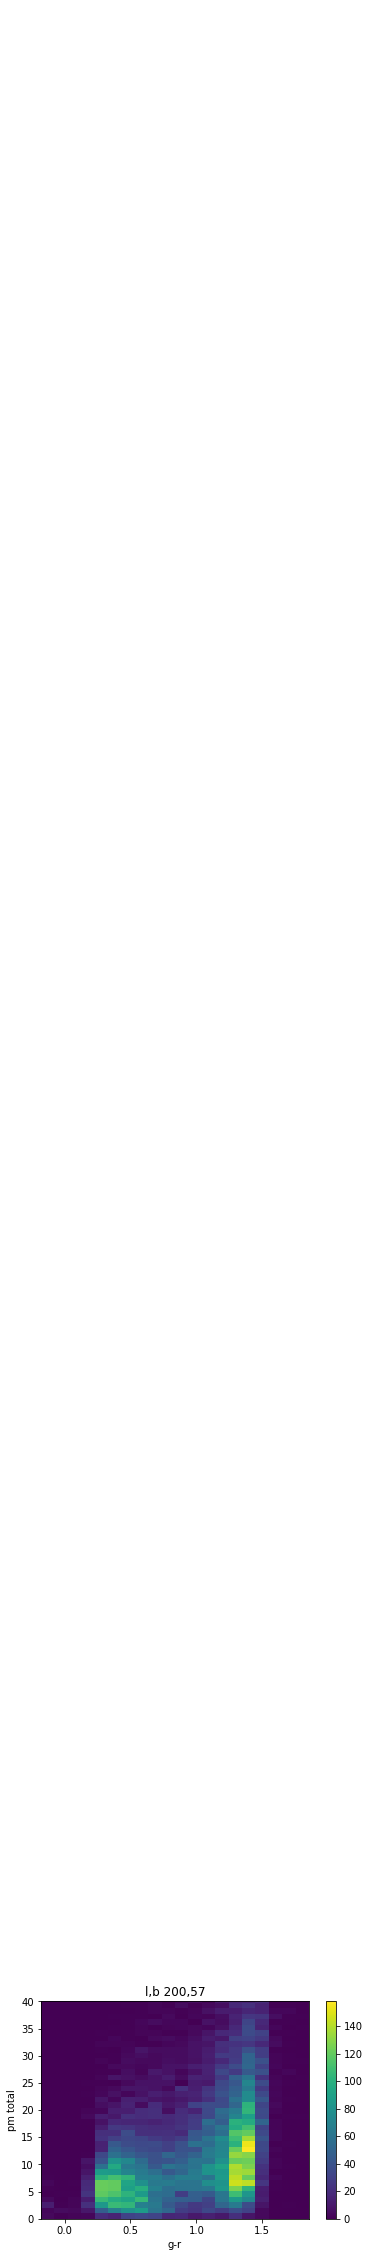

In [193]:
plt.hist2d(gmrall[inbin],pmtotall[inbin],bins=[20,400],cmax=1000)
plt.ylim(0,40)
plt.ylabel('pm total')
plt.xlabel('g-r')
plt.title('l,b 200,57')
plt.ylim(0,40)
plt.colorbar()

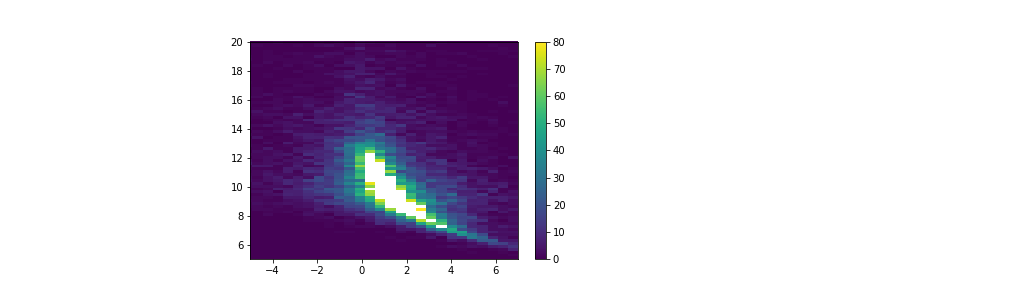

In [177]:
plt.hist2d(pxall[inbin],dmall[inbin],bins=[100,100],cmax=80)
plt.xlim(-5,7)
plt.ylim(5,20)
plt.colorbar()

(5, 22)

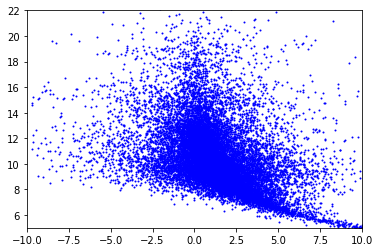

In [178]:
plt.plot(pxall[inbin],dmall[inbin],'bo',mew=0,ms=2.)
plt.xlim(-10,10)
plt.ylim(5,22)

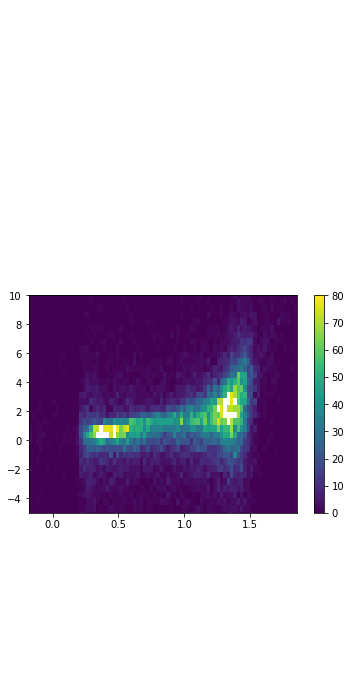

In [181]:
plt.hist2d(gmrall[inbin],pxall[inbin],bins=[80,100],cmax=80)
plt.ylim(-5,10)
plt.colorbar()

In [169]:
ipm, = np.where((gmrall[inbin] < 0.6) | ((pmtotall[inbin] < 3.) & (gmrall[inbin] > 0.6)))

In [170]:
len(gmrall[ipm])

5509

(0.1, 1.6)

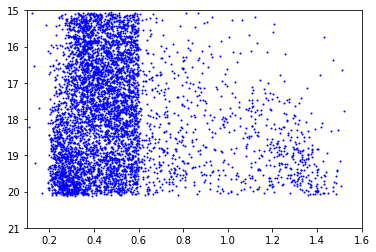

In [171]:
plt.plot(gmrall[inbin[ipm]],rmagall[inbin[ipm]],'bo',mew=0,ms=2.)
plt.ylim(21,15)
plt.xlim(0.1,1.6)

(5, 25)

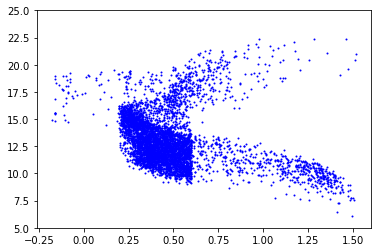

In [172]:
plt.plot(gmrall[inbin[ipm]],dmall[inbin[ipm]],'bo',mew=0,ms=2.)
plt.ylim(5,25)

l,b color-coded by counts in bins

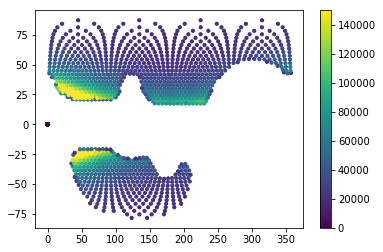

In [76]:
plt.scatter(glongforfullbins,glatforfullbins,c=allbincount,s=10,vmax=150000)
plt.colorbar()

In [85]:
samplefrac_0605.shape

(5, 5, 4)

In [86]:
samplebins_0605.shape

(5, 5, 3072)

In [87]:
samplebins_0605[0,:].shape

(5, 3072)

Completeness per bin with the PM cuts imposed at g-r > 0.5.  According to the plot in Cell 26, the plots for all the DM ranges should be very similar for all the values of the g-r limit I tried except g-r<0.2, which is effectively no g-r cut at all.  Just plot for the PM cut of 3 mas/year to show this.

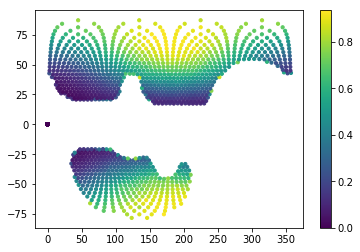

In [104]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0505[1,0,:],s=10)
plt.colorbar()

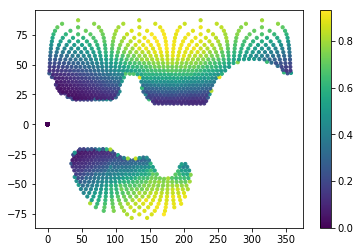

In [105]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0505[1,1,:],s=10)
plt.colorbar()

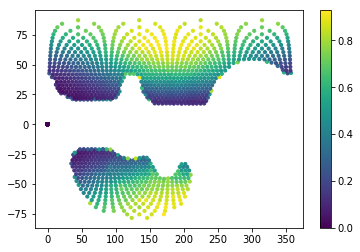

In [94]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0505[1,2,:],s=10)
plt.colorbar()

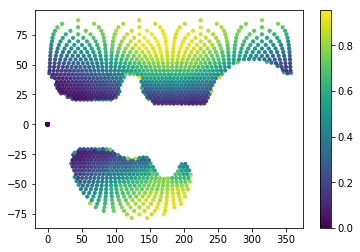

In [106]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0505[1,3,:],s=10)
plt.colorbar()

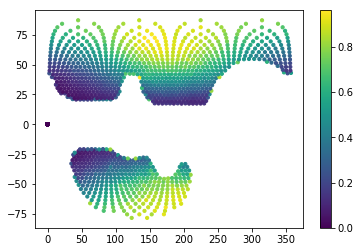

In [107]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0505[1,4,:],s=10)
plt.colorbar()

Now plot the completeness per bin for the other g-r values, just for one DM bin each. 

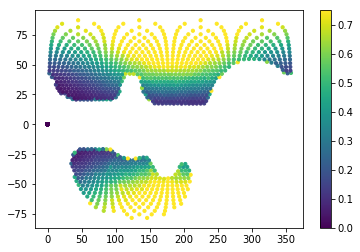

In [112]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0505[1,2,:],s=10,vmax = 0.75)
plt.colorbar()

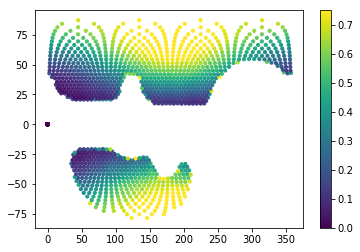

In [108]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0605[1,2,:],s=10,vmax = 0.75)
plt.colorbar()

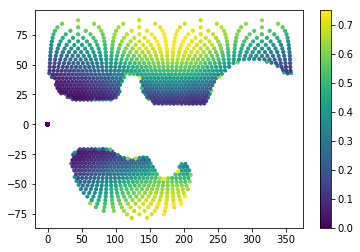

In [109]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0705[1,2,:],s=10,vmax = 0.75)
plt.colorbar()

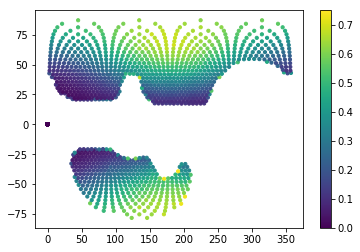

In [110]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0805[1,2,:],s=10,vmax = 0.75)
plt.colorbar()

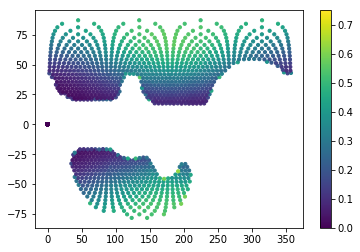

In [111]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_1005[1,2,:],s=10,vmax = 0.75)
plt.colorbar()

Now plot the completeness vs. DM for the case where the PM cut is applied at all g-r. 

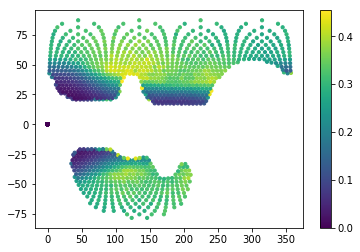

In [99]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0205[1,0,:],s=10)
plt.colorbar()

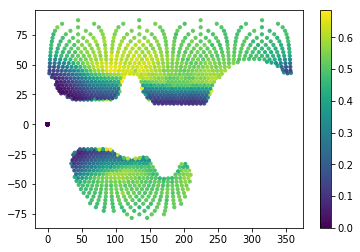

In [100]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0205[1,1,:],s=10)
plt.colorbar()

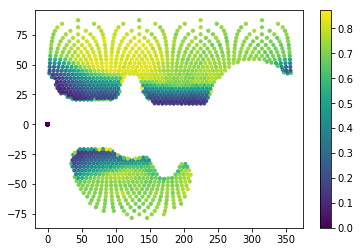

In [101]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0205[1,2,:],s=10)
plt.colorbar()

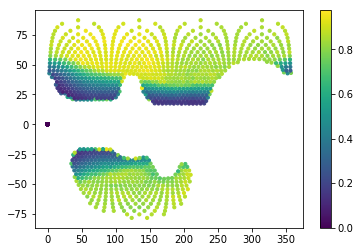

In [102]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0205[1,3,:],s=10)
plt.colorbar()

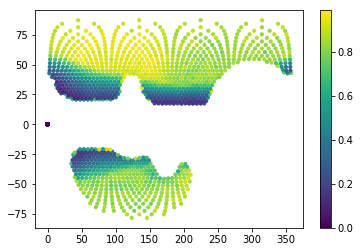

In [103]:
plt.scatter(glongforfullbins,glatforfullbins,c=samplebins_0205[1,4,:],s=10)
plt.colorbar()

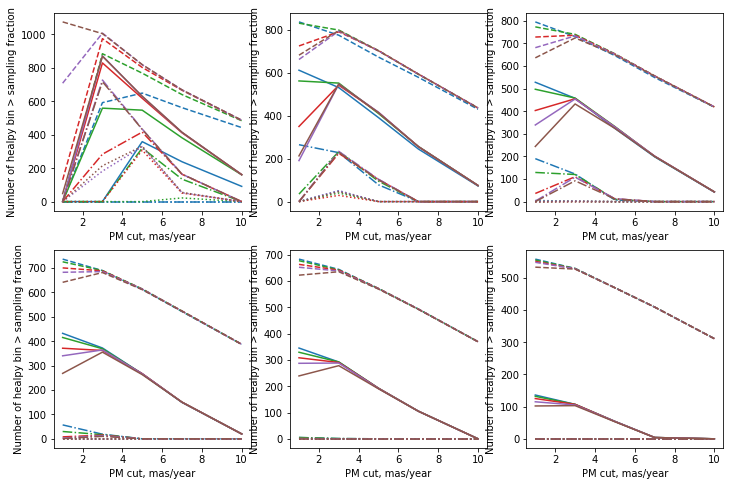

In [203]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
tscompplots(pmcutvec,samplefrac_0205,dmvec,samplefracs)
plt.subplot(2,3,2)
tscompplots(pmcutvec,samplefrac_0505,dmvec,samplefracs)
plt.subplot(2,3,3)
tscompplots(pmcutvec,samplefrac_0605,dmvec,samplefracs)
plt.subplot(2,3,4)
tscompplots(pmcutvec,samplefrac_0705,dmvec,samplefracs)
plt.subplot(2,3,5)
tscompplots(pmcutvec,samplefrac_0805,dmvec,samplefracs)
plt.subplot(2,3,6)
tscompplots(pmcutvec,samplefrac_1005,dmvec,samplefracs)
